# Predicting Reservoir Storage

My project examines Folsom Lake, the 10th largest dam in California and a key water supply for millions of its residents. My goal was to create a model that could use exogenous seasonal variables to predict seasonal water supply and its annual minimum. This project is of utmost importance given California's intensifying climate crisis. Folsom Lake is going increasingly deep in its reserves during the extending droughts, having got to as low as 14% of its capacity in 2014. My ultimate goal is to predict the conditions that would cause Folsom Lake to be unusable, ie. near empty and unavailable for use as a water supply for the millions of people who rely on it, the agricultural companies, and the water-species. 

In [1]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit



## Data Preprocessing

To predict Folsom Lake's water storage, we can take daily data from the US Bureau of Reclamation. There are also 4 exogenous variables of interest which could help in predictions: storage inflow, release, water evaporation, and precipitation. 

In [2]:
#load data from US Bureau of Reclamation

precipitation = pd.read_csv('data/folsomlake_daily_precipitation.csv',header=7) #inch total
storage = pd.read_csv('data/folsomlake_daily_storage.csv',header=7) #acre feet
release = pd.read_csv('data/folsomlake_daily_release.csv',header=7) #avg cfs 24 hr
inflow = pd.read_csv('data/folsomlake_daily_inflow.csv',header=7) #avg cfs 24 hr
evaporation = pd.read_csv('data/folsomlake_daily_evaporation.csv',header=7) #sum cfs 24 hr

In [3]:
#drop unnecessary columns

drop_list = ['Location','Parameter','Timestep','Aggregation','Units']

storage.drop(drop_list,axis=1,inplace=True)
precipitation.drop(drop_list,axis=1,inplace=True)
evaporation.drop(drop_list,axis=1,inplace=True)
release.drop(drop_list,axis=1,inplace=True)
inflow.drop(drop_list,axis=1,inplace=True)

In [4]:
#import NOAA weather data from nearby Colfax data

noaa = pd.read_csv('data/colfax_data.csv')

#from 1966 onwards

start_date = "1967-01-01"
end_date = "2020-01-01"

noaa = noaa[(noaa['DATE'] >= start_date) & (noaa['DATE'] < end_date)]

noaa.tail()

STATION           NAME        DATE  DAPR  MDPR  PRCP  SNOW  SNWD  \
21262  USC00041912  COLFAX, CA US  2019-12-27   NaN   NaN   0.0   NaN   NaN   
21263  USC00041912  COLFAX, CA US  2019-12-28   NaN   NaN   0.0   NaN   NaN   
21264  USC00041912  COLFAX, CA US  2019-12-29   NaN   NaN   0.0   NaN   NaN   
21265  USC00041912  COLFAX, CA US  2019-12-30   NaN   NaN   0.0   NaN   NaN   
21266  USC00041912  COLFAX, CA US  2019-12-31   NaN   NaN   0.0   NaN   NaN   

       TMAX  TMIN  TOBS  
21262  53.0  27.0   NaN  
21263  57.0  34.0   NaN  
21264  45.0  38.0   NaN  
21265  64.0  32.0   NaN  
21266  58.0  39.0   NaN

In [5]:
#clean noaa
noaa['date'] = pd.to_datetime(noaa['DATE']).dt.date

noaa.drop(['STATION','NAME','DAPR','MDPR','TOBS','DATE','PRCP'],axis=1,inplace=True)



noaa.set_index('date',inplace=True)
noaa.index = pd.to_datetime(noaa.index)

In [6]:
#to match up data we take only from 1966 onwards


storage = storage[(storage['Datetime (UTC)'] >= start_date) & (storage['Datetime (UTC)'] <= end_date)]

precipitation = precipitation[(precipitation['Datetime (UTC)'] >= start_date) & (precipitation['Datetime (UTC)'] <= end_date)]

release = release[(release['Datetime (UTC)'] >= start_date) & (release['Datetime (UTC)'] <= end_date)]

evaporation = evaporation[(evaporation['Datetime (UTC)'] >= start_date) & (evaporation['Datetime (UTC)'] <= end_date)]

inflow = inflow[(inflow['Datetime (UTC)'] >= start_date) & (inflow['Datetime (UTC)'] <= end_date)]

storage.tail()

Result       Datetime (UTC)
22946  516118.0  2019-12-27 08:00:00
22947  515714.0  2019-12-28 08:00:00
22948  514744.0  2019-12-29 08:00:00
22949  513128.0  2019-12-30 08:00:00
22950  511115.0  2019-12-31 08:00:00

In [7]:
#convert cols to datetime, simplify name

storage['date']= pd.to_datetime(storage['Datetime (UTC)']).dt.date
precipitation['date']= pd.to_datetime(precipitation['Datetime (UTC)']).dt.date
evaporation['date']= pd.to_datetime(evaporation['Datetime (UTC)']).dt.date
release['date']= pd.to_datetime(release['Datetime (UTC)']).dt.date
inflow['date']= pd.to_datetime(inflow['Datetime (UTC)']).dt.date

#collect dates in df for future time series

ts_date = storage['date']


#drop duplicate
storage.drop('Datetime (UTC)',axis=1,inplace=True)
precipitation.drop('Datetime (UTC)',axis=1,inplace=True)
evaporation.drop('Datetime (UTC)',axis=1,inplace=True)
release.drop('Datetime (UTC)',axis=1,inplace=True)
inflow.drop('Datetime (UTC)',axis=1,inplace=True)


#set date as index

storage.set_index('date',inplace=True)
precipitation.set_index('date',inplace=True)
evaporation.set_index('date',inplace=True)
release.set_index('date',inplace=True)
inflow.set_index('date',inplace=True)


#set index to datetime format

storage.index = pd.to_datetime(storage.index)
precipitation.index = pd.to_datetime(precipitation.index)
evaporation.index = pd.to_datetime(evaporation.index)
release.index = pd.to_datetime(release.index)
inflow.index = pd.to_datetime(inflow.index)

storage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19358 entries, 1967-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Result  19358 non-null  float64
dtypes: float64(1)
memory usage: 302.5 KB


In [8]:
#rename cols from result to specific 

storage.rename(columns= {'Result': 'storage'},inplace=True)
precipitation.rename(columns= {'Result': 'precipitation'},inplace=True)
evaporation.rename(columns= {'Result': 'evaporation'},inplace=True)
release.rename(columns= {'Result': 'release'},inplace=True)
inflow.rename(columns= {'Result': 'inflow'},inplace=True)


In [9]:
#merge datasets
from functools import reduce
df_list = [noaa,precipitation,evaporation, inflow, release,storage]

data = reduce(lambda left,right: pd.merge(left,right,on=['date'],how='outer'),df_list)

#set index to datetime index

data.index = pd.to_datetime(data.index)
print(data.info())

#fill null values in exogenous var's

data.fillna('value=0',inplace=True)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19358 entries, 1967-01-01 to 2016-07-14
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SNOW           16561 non-null  float64
 1   SNWD           15970 non-null  float64
 2   TMAX           18446 non-null  float64
 3   TMIN           18443 non-null  float64
 4   precipitation  19358 non-null  float64
 5   evaporation    19356 non-null  float64
 6   inflow         19358 non-null  float64
 7   release        19358 non-null  float64
 8   storage        19358 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19358 entries, 1967-01-01 to 2016-07-14
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SNOW           19358 non-null  object 
 1   SNWD           19358 non-null  object 
 2   TMAX           19358 non-null  object 
 

As seasonal cumulative rainfall has a big impact on reservoir capacity, we will create a precipitation to date column, labeled total_rain_to_date.

## Exploratory Data Analysis

The majority of our analysis centers around storage, the target variable. We notice how the data variance rapidly shifted from the 1990's onwards. This makes sense as California's climate has increasingly destabilized, resulting in more need for reservoir water.

<AxesSubplot:xlabel='date'>

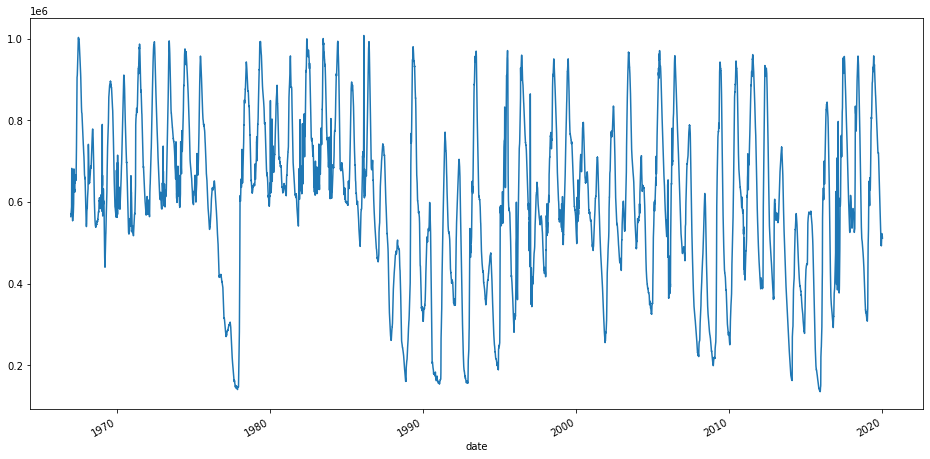

In [10]:
data.storage.plot(figsize=(16,8))

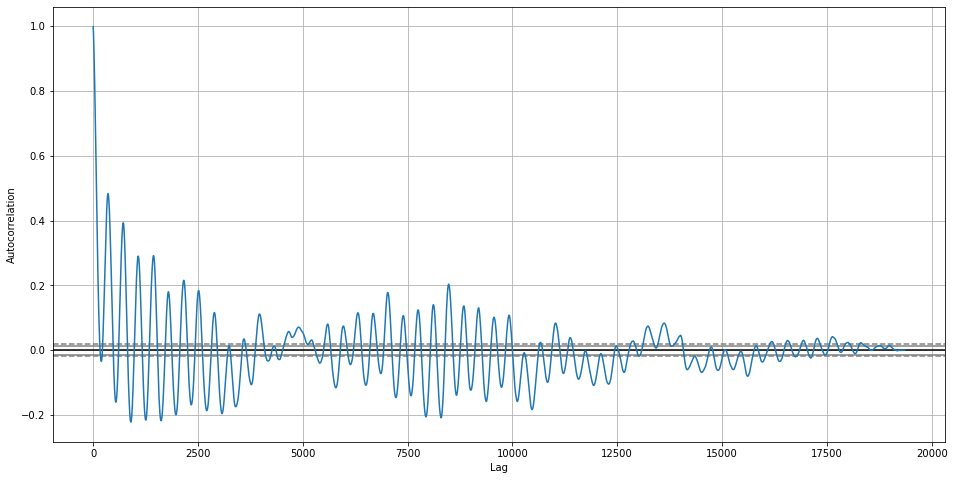

In [11]:
fig, ax1 = plt.subplots(figsize = (16,8))

pd.plotting.autocorrelation_plot(data['storage'],ax=ax1)
plt.show();

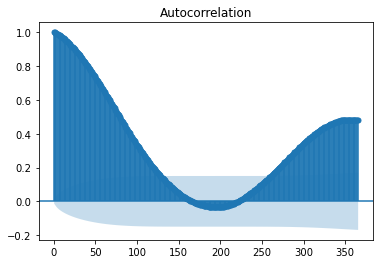

In [12]:
plot_acf(data['storage'],lags=365);

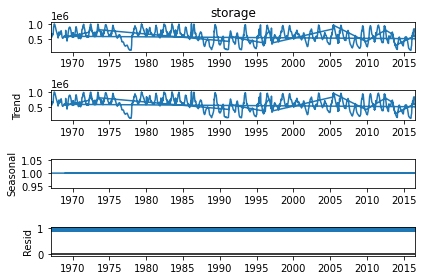

In [13]:
result = seasonal_decompose(pd.Series(data['storage']),model='multiplicative', period=1)

result.plot()
plt.show();

Below, we examine the correlation of reservoir storage data to the past day or past year, and we find it is heavily correlated between the past day, forming an almost perfect line. However, it is surprising the variability year to year. This must be because of the variability in rainfall and seasons in California's diverse climate.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

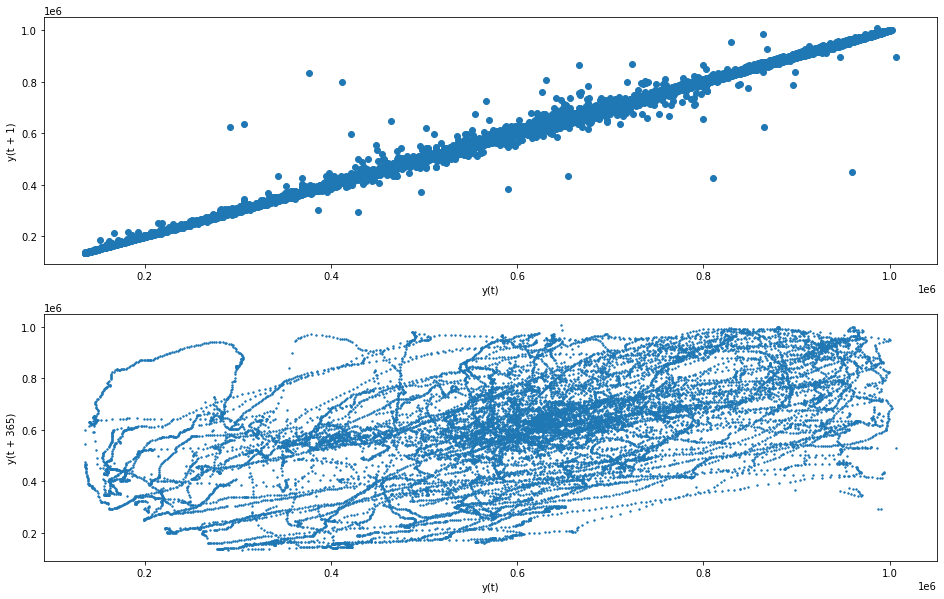

In [14]:

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
pd.plotting.lag_plot(data['storage'],ax=ax1,lag=1)
pd.plotting.lag_plot(data['storage'],ax=ax2,lag=365,s=2)


Examining the storage year after year might tell us why there is so much outlier data.

In [15]:
storage_copy = data['storage'].to_frame()
print(storage_copy.info())

storage_copy

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19358 entries, 1967-01-01 to 2016-07-14
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   storage  19358 non-null  float64
dtypes: float64(1)
memory usage: 302.5 KB
None


storage
date                
1967-01-01  564011.0
1967-01-02  565656.0
1967-01-03  567315.0
1967-01-04  569323.0
1967-01-05  571243.0
...              ...
2013-08-31  429368.0
2013-10-30  294332.0
2013-10-31  291529.0
2016-07-13  624513.0
2016-07-14  617685.0

[19358 rows x 1 columns]

The rainy season in California is Winter through Early Spring. No rainfall in the summers is common.

<AxesSubplot:xlabel='date'>

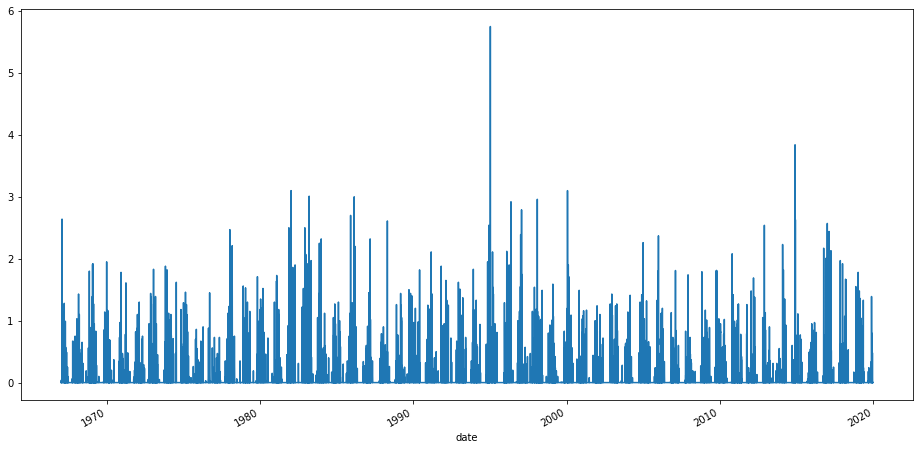

In [17]:
data['precipitation'].plot(figsize=(16,8))

In [ ]:
data['precipitation'].plot(figsize=(16,8))

### Testing for Stationarity

# Modelling

### Data Preparation

To prepare the data to be inputted into an ARIMA model, we are going to group up the data in monthly levels. This will allow the seasonal calculations to take place. The variables we will use are: 
-avg max temp
-sum of annual rainfall to date
-avg daily evaporation


### A Basic Model

We first start with a seasonal basic autoregressive model. The only input variables are previous capacity values.